In [14]:
import gym
import numpy as np
import keras
import random
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
def to_greyscale(img): # later on, let's turn these binary
    return np.mean(img, axis=2).astype(np.uint8)

def rgb_to_gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray.astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return rgb_to_gray(downsample(img))

In [153]:
# We assume a theano backend here, so the "channels" are first.
#ATARI_SHAPE = (4, 105, 80)

# tf backend
#ATARI_SHAPE = (105, 80, 2)
ATARI_SHAPE = (105, 80, 1) # using diff images

# With the functional API we need to define the inputs.
frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
#actions_input = keras.layers.Input((n_actions,), name='mask')

# Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)

#still want to normalize these, although greyscaled already

# "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
conv_1 = keras.layers.convolutional.Convolution2D(
    16, 8, 8, subsample=(4, 4), activation='relu'
)(normalized)
# "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
conv_2 = keras.layers.convolutional.Convolution2D(
    32, 4, 4, subsample=(2, 2), activation='relu'
)(conv_1)
# Flattening the second convolutional layer.
conv_flattened = keras.layers.core.Flatten()(conv_2)

# "The final hidden layer is fully-connected and consists of 256 rectifier units."
hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)

# "The output layer is a fully-connected linear layer with a single output for each valid action."
#output = keras.layers.Dense(4)(hidden) # number of actions
output = keras.layers.Dense(2)(hidden) # number of actions--only allowing useful moves

#model = keras.models.Model(input=[frames_input, actions_input], output=filtered_output)
atari_model = keras.models.Model(input=frames_input, output=output)
optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
atari_model.compile(optimizer, loss='mse')

/home/beans/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), strides=(4, 4), activation="relu")`
/home/beans/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), strides=(2, 2), activation="relu")`
/home/beans/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("fr...)`


In [235]:
#env = gym.make("BreakoutDeterministic-v4")
env = gym.make("Pong-v0")

gamma = 0.9
buffer = 10000
batchSize = 32
epsilon = 1

rewards = []

replay = []
h = 0

model = atari_model

In [157]:
frame_old = env.reset()
frame_new, reward, is_done, _ = env.step(env.action_space.sample())

In [131]:
env.action_space
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

0.0


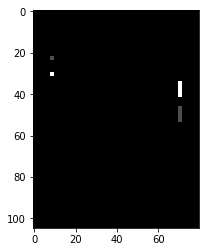

In [151]:
frame_new, reward, is_done, _ = env.step(env.action_space.sample())
print(reward)
env.render()
plt.imshow(preprocess(frame_new)-preprocess(frame_old), cmap="gray")
frame_old = frame_new

In [40]:
frame_old.shape

(210, 160, 3)

[[ 0.00204902  0.00154707]]
AxesImage(54,36;334.8x217.44)


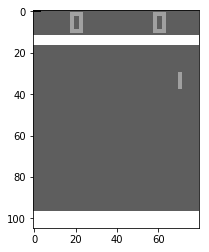

In [261]:

# STATE
orig_state = preprocess(frame_old) - preprocess(frame_new)

# ACTION
Qvals = model.predict(orig_state.reshape(1,105,80,1), batch_size=1)
maxQ_ix = np.argmax(Qvals)

print(Qvals)
frame_old = frame_new

# take optimal choice
action = maxQ_ix 

# NEW STATE, REWARD
frame_new, reward, is_done, _ = env.step(action)

print(plt.imshow(preprocess(frame_new), cmap="gray"))

In [ ]:
for i in range(2):
    print("game #", i)
    # doing first two steps here to get enough for initial state
    
    frame_old = env.reset()

    frame_new, reward, is_done, _ = env.step(2 if random.random()<.5 else 3) #random


    while not is_done:
        # STATE
        orig_state = preprocess(frame_old) - preprocess(frame_new)

        # ACTION
        Qvals = model.predict(orig_state.reshape(1,105,80,1), batch_size=1)
        maxQ_ix = np.argmax(Qvals)

        frame_old = frame_new

        if random.random()>epsilon:
            action = maxQ_ix
            # take optimal choice
        else:
            action = 2 if random.random()<.5 else 3
            # take random choice
        if epsilon > .1: epsilon -= .9e-06

        # NEW STATE, REWARD
        frame_new, reward, is_done, _ = env.step(action)

        # new state 
        new_state = preprocess(frame_new) - preprocess(frame_old)

        reward = np.sign(reward)

        #Experience replay storage
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((orig_state, action, reward, new_state))
        else: 
            if (h < (buffer-1)):
                h += 1
            else:
                h = 0

            replay[h] = (orig_state, action, reward, new_state)

            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)

            X_train = []
            y_train = []
            for memory in minibatch:
                #Get max_Q(S',a)
                old_state, action, reward, new_state = memory
                old_qval = model.predict(old_state.reshape(1,105,80,1), batch_size=1)

                newQ = model.predict(new_state.reshape(1,105,80,1), batch_size=1)
                maxQ = np.max(newQ)
                y = np.zeros((1,2))
                y[:] = old_qval[:]
                update = (reward + (gamma * maxQ))

                y[0][0 if action == 2 else 1] = update
                X_train.append(old_state)
                y_train.append(y)

                """
                print("old qvals", old_qval)
                print("action", action)
                print("reward: ", reward)
                print("new q vals ", newQ)
                print("update", update)
                print("fitting with the following y:", y, "\n\n")
                """

            X_train = np.array(X_train).reshape(batchSize, 105, 80, 1)
            y_train = np.array(y_train).reshape(batchSize, 2)

            #print("Game #: %s" % (i,))
            model.fit(X_train, y_train, batch_size=batchSize, epochs=1, verbose=0)

    #env.render()

    print(plt.imshow(new_state, cmap="gray"))
    #env.close()
    print("saving model...")
    model.save("pong.h5")




#env.render()

In [258]:
X_train.shape

(2, 105, 80)

In [22]:
# for testing
frame_old = env.reset()

frame_new, reward, is_done, _ = env.step(env.action_space.sample())

while not is_done:
    # STATE
    orig_state = np.array([preprocess(frame_old), preprocess(frame_new)]).reshape(105, 80, 2)

    # ACTION
    Qvals = model.predict(orig_state.reshape(1,105,80,2), batch_size=1)
    maxQ_ix = np.argmax(Qvals)

    frame_old = frame_new

    # take optimal choice
    action = maxQ_ix 

    # NEW STATE, REWARD
    frame_new, reward, is_done, _ = env.step(action)
    

    env.render(mode='rgb_array')    
#ax.imshow(preprocess(frame_old), cmap="gray") 

In [23]:
env.close()